In [6]:
'''
__author__ = 'Alex Cheng'
ensemble集成方法：bagging, boosting, RF

Gradient Boosting：梯度提升算法是基于决策树的集成方法，在不同标签上训练决策树，
然后组合起来，对于回归问题，目标是最小化均方误差，每个后续的决策树是在前面
决策树遗留的错误上进行训练的,梯度提升持续监测自己的累计误差，然后使用残差进行后续训练，
训练的目标是前期所有基学习期的累计误差


梯度提升法在减少方差的同时，还能减少偏差，它在深度为1的决策树情况下，也可以获得
同更深的决策树一样低的均方误差值

对于梯度提升法，只有属性之间有强烈的互相影响的情况下，才需要考虑增加决策树的深度，
随着决策树深度的增加，性能获得了改善实际上可以作为判断属性之间是否存在相互影响的方法

eps: 在优化问题时控制步长，步长太大，优化可能会发散而不是收敛，如果步长太少，可能需要太多次迭代
残差：预测误差，开始阶段初始化预测值为空Null或0，因此残差等于观测值

决策树的每一层约花费相同的时间


深度为1的决策树的集成方法相对于当个决策树在均方误差方面的改善可以忽略不计
红酒数据有多个属性，因此多个属性的组合对预测的贡献要远大于单独每个属性对预测的贡献
注意：本例测试中，Boosting对红酒的回归预测表现不错

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.externals.six import StringIO
from math import sqrt
import random

In [7]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
"wine-quality/winequality-red.csv")
df = pd.read_csv(target_url,header=0,sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
names = df.columns

# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# 固定 30%采样
nsample = int(nrows * 0.30)
idxTest = random.sample(range(nrows),nsample) # 随机30%抽取
idxTest.sort()
idxTrain = [idx for idx in range(nrows) if not(idx in idxTest)]

# 定义测试和训练的属性和列表
xTrain = [xList[r] for r in idxTrain]
xTest  = [xList[r] for r in idxTest]
yTrain = [labels[r] for r in idxTrain]
yTest  = [labels[r] for r in idxTest] # 列向量

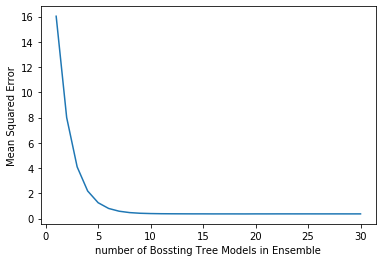

Min MSE with Boosting treeDepth 5 maxTree 30 : 0.37338621754435264


In [9]:
# 训练一些列模型在随机训练样本集
numTreeMax = 30
treeDepth = 5
modelList = [] # 模型列表
predList = [] # 预测

eps = 0.3
residuals = list(yTrain)

for iTree in range(numTreeMax):
    
    modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
    modelList[-1].fit(xTrain, residuals) # 不是yTest,而是残差
    
    # 最新的训练集预测
    latestInSamplePred = modelList[-1].predict(xTrain)
    
    # 使用新的预测去更新残差
    residuals = [residuals[i] - eps * latestInSamplePred[i] 
                 for i in range(len(residuals))]
    
    # 预测测试集
    latestOutSamplePred = modelList[-1].predict(xTest)
    predList.append(latestOutSamplePred)

# 前n个模型
mse = []
allPred = []
for iModel in range(len(modelList)):
    pred = []
    for iTest in range(len(xTest)):
        # 前n个，注意iModel从0开始，所以要加+1
        # 注意前面残差计算方法，所里这里是 求和*eps
        pred.append(sum([predList[i][iTest] for i in range(iModel + 1)]) * eps) 
        
    allPred.append(pred)
    errors = [(yTest[i] - pred[i]) for i in range(len(yTest))]
    mse.append(sum([e * e for e in errors]) / len(yTest))

nModels = [i+1 for i in range(len(modelList))]
plt.plot(nModels,mse)
plt.axis('tight')
plt.xlabel('number of Bossting Tree Models in Ensemble')
plt.ylabel('Mean Squared Error')
#plt.ylim(0.0,max(mse))
plt.show() 

# 之前相同的树深和最大树数量，最小误差是0.44， 现在是0.01
print('Min MSE with Boosting treeDepth',treeDepth,'maxTree',numTreeMax, ":", min(mse))